In [163]:
import jax.numpy as jnp
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
model_type = "tensor_gru"
H_type = "cluster"
L = 64
p = 1
units = 128
numsamples = 512
dmrg = False
seed = 3
angle_list = [0.0, 0.157, 0.314, 0.471, 0.628, 0.785, 0.942, 1.1, 1.257, 1.414, 1.571]
meanE_ES = []
meanE_cluster = []
evalE_ES = []
evalvar_ES = []
evalE_cluster = []
evalvar_cluster = []

for i in angle_list:
    meanE_ES.append(np.load("result/meanE_1DRNN_HtypeES_L64_patch1_units128_batch256_dmrgFalse_seed3_angle"+str(i)+".npy").ravel().tolist())
    meanE_cluster.append(np.load("result/meanE_1DRNN_Htypecluster_L64_patch1_units128_batch256_dmrgFalse_seed3_angle"+str(i)+".npy").ravel().tolist())
    evalE_ES.append(np.load("result/evalmeanE_1DRNN_HtypeES_L64_patch1_units128_batch256_dmrgFalse_seed3_angle"+str(i)+".npy").ravel().tolist())
    evalvar_ES.append(np.load("result/evalvarE_1DRNN_HtypeES_L64_patch1_units128_batch256_dmrgFalse_seed3_angle"+str(i)+".npy").ravel().tolist())
    evalE_cluster.append(np.load("result/evalmeanE_1DRNN_Htypecluster_L64_patch1_units128_batch256_dmrgFalse_seed3_angle"+str(i)+".npy").ravel().tolist())
    evalvar_cluster.append(np.load("result/evalvarE_1DRNN_Htypecluster_L64_patch1_units128_batch256_dmrgFalse_seed3_angle"+str(i)+".npy").ravel().tolist())


In [164]:
evalvar_ES

[[0.0007376882713288069],
 [0.024983353912830353],
 [0.07299971580505371],
 [0.12390616536140442],
 [0.025022344663739204],
 [0.039339449256658554],
 [0.004603410605341196],
 [0.0008415644988417625],
 [4.93437000841368e-05],
 [4.129779335926287e-05],
 [3.749602547031827e-05]]

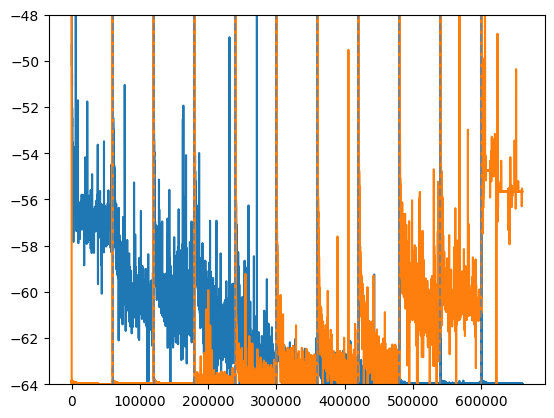

In [154]:
plt.plot(np.arange(len(np.array(meanE_ES).ravel())), np.array(meanE_ES).ravel().real)
plt.plot(np.arange(len(np.array(meanE_cluster).ravel())), np.array(meanE_cluster).ravel().real)
for i in range(1, 11):
    plt.axvline(x=i*60000, color="gray", linestyle="--")
plt.ylim(-64, -48)

plt.show()

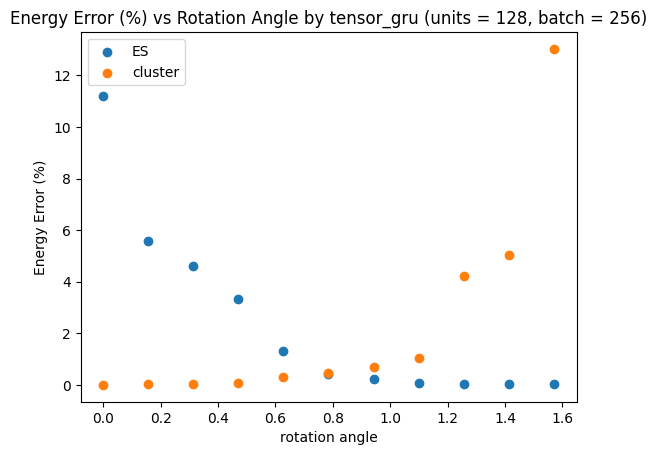

In [167]:
plt.scatter(np.array(angle_list), ((np.array(evalE_ES)+64).real/64*100).ravel(), label = "ES")
plt.scatter(np.array(angle_list), ((np.array(evalE_cluster)+64).real/64*100).ravel(), label = "cluster")
plt.xlabel("rotation angle")
plt.ylabel("Energy Error (%)")
plt.title("Energy Error (%) vs Rotation Angle by tensor_gru (units = 128, batch = 256)")
plt.legend()
plt.show()

In [10]:
import torch
import torch.nn as nn
m = nn.ZeroPad2d(2)
input = torch.randn(1, 1, 3, 3)
input
m(input)
# using different paddings for different sides
m = nn.ZeroPad2d((0, 0, 1, -1))
m(input)

tensor([[[[ 0.0000,  0.0000,  0.0000],
          [ 1.1325, -0.5770,  0.4798],
          [-0.2277, -0.3857, -0.1964]]]])

In [18]:
import jax
a1, a2, a3 = jnp.ones((3, 4))

In [19]:
a1

Array([1., 1., 1., 1.], dtype=float32)

In [20]:
x = jnp.ones(3)


In [23]:
jnp.ones((3, 4)) + jnp.ones(3)[:, None]

Array([[2., 2., 2., 2.],
       [2., 2., 2., 2.],
       [2., 2., 2., 2.]], dtype=float32)

In [30]:
a = jnp.ones(3)
b = jnp.ones((3, 2, 4))
jnp.bmm(a, b)

AttributeError: module 'jax.numpy' has no attribute 'bmm'

In [32]:
import optax
lr = 0.1
boundaries_and_scales = {
    8000: 0.5,  # After 1000 steps, scale the learning rate by 0.1
    24000: 0.5  # After 2000 steps, scale the learning rate by 0.01
}
lr_schedule = optax.piecewise_constant_schedule(
    init_value=lr,
    boundaries_and_scales=boundaries_and_scales
)
for step in [5000, 15000, 25000]:
    print(f"Step {step}: learning rate = {lr_schedule(step)}")

Step 5000: learning rate = 0.10000000149011612
Step 15000: learning rate = 0.05000000074505806
Step 25000: learning rate = 0.02500000037252903


In [65]:
import netket as nk
from netket.operator.spin import sigmax,sigmaz 
N = 20
hi = nk.hilbert.Spin(s=1 / 2, N=N)
Gamma = -1
H = sum([Gamma*sigmax(hi,i) for i in range(N)])
V=-1
H += sum([V*sigmaz(hi,i)*sigmaz(hi,(i+1)%N) for i in range(N)])

In [77]:
import flax
import flax.linen as nn

class JasShort(nn.Module):
    @nn.compact
    def __call__(self, x):
        
        # Define the two variational parameters J1 and J2
        j1 = self.param(
            "j1", nn.initializers.normal(), (20,), float
        )
        j2 =self.param(
            "j2", nn.initializers.normal(), (20,), float
        )

        # compute the nearest-neighbor correlations
        corr1=x*jnp.roll(x,-1,axis=-1)
        corr2=x*jnp.roll(x,-2,axis=-1)

        # sum the output
        return jnp.sum(j1*corr1+j2*corr2,axis=-1)
    
model=JasShort()
sampler = nk.sampler.MetropolisLocal(hi)


In [148]:
import time
vs = nk.vqs.MCState(sampler, model, n_samples=1008)
sr = nk.optimizer.SR(diag_shift=0.1)
op = nk.optimizer.Sgd(learning_rate=0.05)
gs = nk.VMC(
    hamiltonian=H,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(out='RBM', n_iter=100)
end = time.time()

print('### RBM calculation')
print('Has',vs.n_parameters,'parameters')
print('The RBM calculation took',end-start,'seconds')

  0%|          | 0/100 [00:00<?, ?it/s]

### RBM calculation
Has 40 parameters
The RBM calculation took 1.4107000827789307 seconds


In [129]:
import jax
import jax.numpy as jnp
from jax import lax, vmap, jit

def log_phase_dmrg(samples, M0, M, Mlast, netket=False):
    samples = lax.cond(
        netket,
        lambda x: ((x + 1) // 2).astype(jnp.int32),  # Adjusted to integer division
        lambda x: x.astype(jnp.int32),
        samples
    )
    
    # Rest of your function implementation
    vec_init = M0[samples[0]]
    vec_last = Mlast[samples[-1]]
    N = samples.shape[0]
    n_indices = jnp.arange(N - 2)
    
    def scan_fun(vec, n):
        idx = samples[n + 1]
        vec = M[idx, :, :, n] @ vec
        return vec, None
    
    amp_last, _ = lax.scan(scan_fun, vec_init, n_indices)
    amp = jnp.dot(amp_last, vec_last)
    sign = amp / jnp.abs(amp)
    
    log_phase = lax.cond(
        jnp.abs(amp) > 1e-12,
        lambda _: (-sign + 1) / 2 * jnp.pi * 1j,
        lambda _: 0.0 + 0.0 * 1j,
        operand=None
    )
    return log_phase

# Batch the function with `vmap`, specifying `in_axes`
batch_log_phase_dmrg = jit(
    vmap(log_phase_dmrg, in_axes=(0, None, None, None, None))
)

# Example usage
batch_size = 5
sample_length = 10

# Create batched samples (shape: [batch_size, sample_length])
samples = jnp.zeros((batch_size, sample_length), dtype=jnp.int32)

# M0, M, and Mlast should be properly shaped arrays
# Adjust the shapes according to your specific needs
M0 = np.random.randn(2, 3)
M = np.random.randn(2, 3, 3, sample_length - 2)
Mlast = np.random.randn(2, 3)

# Since `netket` is optional and defaults to False, you can omit it
result = batch_log_phase_dmrg(samples, M0, M, Mlast, True)
print(result)


[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [149]:
vs.parameters

{'j1': Array([0.231504  , 0.23663967, 0.23380992, 0.23125583, 0.23144165,
        0.23320781, 0.23539094, 0.23293803, 0.23221554, 0.23356096,
        0.22727734, 0.23534151, 0.23453261, 0.23197756, 0.22758022,
        0.23409958, 0.22722789, 0.23560004, 0.2308428 , 0.23335121],      dtype=float64),
 'j2': Array([0.08437635, 0.0787591 , 0.08300399, 0.07982091, 0.08350357,
        0.08216407, 0.08267056, 0.07962981, 0.08200861, 0.08086664,
        0.08015472, 0.07740785, 0.08042063, 0.08327323, 0.08230333,
        0.08722543, 0.08474279, 0.08139716, 0.08373156, 0.07803473],      dtype=float64)}

In [85]:
va = nk.vqs.MCState(sampler, model, n_samples=1008)
va.parameters = a
ga = nk.VMC(
    hamiltonian=H,
    optimizer=op,
    preconditioner=sr,
    variational_state=va)
start = time.time()
ga.run(out='RBM', n_iter=100)
end = time.time()

  0%|          | 0/100 [00:00<?, ?it/s]

In [137]:
a = jnp.array([1, 2, 3])

In [140]:
a[4]

Array(3, dtype=int64)

In [145]:
import msgpack
with open('RBM0L=16_numsample=256.mpack', 'rb') as f:
    data = flax.serialization.from_bytes(, f.read())

In [147]:
f

<_io.BufferedReader name='RBM0L=16_numsample=256.mpack'>